In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-poster')
from datetime import datetime as dt
from datetime import timedelta
import glob
    
from Reff_functions import *
from Reff_constants import *
from scipy.stats import gamma


In [2]:
#Code taken from read_in_cases from Reff_functions. Preprocessing was not helpful for this situation.

case_file_date='31Jul'
path = "../data/COVID-19 UoM "+case_file_date+"*.xlsx"

for file in glob.glob(path):
    df_NNDSS = pd.read_excel(file,
                       parse_dates=['SPECIMEN_DATE','NOTIFICATION_DATE','NOTIFICATION_RECEIVE_DATE','TRUE_ONSET_DATE'],
                       dtype= {'PLACE_OF_ACQUISITION':str})
    df_NNDSS.PLACE_OF_ACQUISITION.fillna('00038888',inplace=True) #Fill blanks with simply unknown

   # df_NNDSS['date_inferred'] = df_NNDSS.TRUE_ONSET_DATE
  #  df_NNDSS.loc[df_NNDSS.TRUE_ONSET_DATE.isna(),'date_inferred'] = df_NNDSS.loc[df_NNDSS.TRUE_ONSET_DATE.isna()].NOTIFICATION_DATE - timedelta(days=5)
  #  df_NNDSS.loc[df_NNDSS.date_inferred.isna(),'date_inferred'] = df_NNDSS.loc[df_NNDSS.date_inferred.isna()].NOTIFICATION_RECEIVE_DATE - timedelta(days=6)    
df_NNDSS['imported'] = df_NNDSS.PLACE_OF_ACQUISITION.apply(lambda x: 1 if x[-4:]=='8888' and x != '00038888' else 0)
df_NNDSS['local'] = 1 - df_NNDSS.imported

df_interim = df_NNDSS[['NOTIFICATION_DATE','STATE','imported','local']] 
# Importantly, imported and local are indicator variables in df_interim.

#df_state = df_NNDSS[['NOTIFICATION_DATE','STATE','imported','local']].groupby(['STATE','NOTIFICATION_DATE']).sum()

In [3]:
df_interim = df_interim[~df_interim.NOTIFICATION_DATE.isna()] #Get rid of non-existent dates.

In [4]:
#Filter out territories
df_linel = df_interim[(df_interim['STATE']!='NT') & (df_interim['STATE']!='ACT')]
df_linel.head()
#df_linel['STATE'].unique()

,NOTIFICATION_DATE,STATE,imported,local
113,2020-07-30,NSW,0,1
114,2020-07-30,NSW,0,1
115,2020-07-30,NSW,0,1
116,2020-07-29,NSW,0,1
117,2020-07-30,NSW,0,1


## Part 1: Inferring infection dates
$\Lambda$ depends on the infection date (ID), while the data contains the notification date (ND). We obtain ID through the following relationship:
$$
ID = ND - reporting\_delay - incubation\_period.
$$



A gamma distribution was fitted to case data using the MLE algorithm to produce distributions for reporting delay and incubation period. 

In [5]:
#gamma draws take arguments (shape, scale)
def create_inf_dates(notification_dates, mean_rd=5.47, sd_rd=4.04,
                    mean_inc=2.0, sd_inc=1.41, nreplicates=1):

    nsamples = notification_dates.shape[0]

#    DEFINE DELAY DISTRIBUTION
#     mean_rd = 5.47
#     sd_rd = 4.04
    scale_rd = mean_rd/(sd_rd)**2
    shape_rd = mean_rd/scale_rd

    # DEFINE INCUBATION PERIOD DISTRIBUTION
#     mean_inc = 2.0
#     sd_inc = 1.41
    scale_inc = mean_inc/(sd_inc)**2
    shape_inc = mean_inc/scale_inc
    
    #Draw from distributions
    inc_period = np.random.gamma(shape_inc, scale_inc, size = (nsamples))
    rep_delay = np.random.gamma(shape_rd, scale_rd, size = (nsamples))
    
    #infection date is id_nd_diff days before notification date.
    id_nd_diff = inc_period + rep_delay
    
    #Minutes aren't included in df. Take the ceiling because the day runs from 0000 to 2359.
    whole_day_diff = np.ceil(id_nd_diff) 
    
    #Subtract days off of notification dates.
    infection_dates = notification_dates - whole_day_diff.astype('timedelta64[D]')
    
    return(infection_dates)

In [6]:
#Add infection dates to original data frame.
df_interim.loc[:,'infection_date'] = create_inf_dates(df_interim['NOTIFICATION_DATE'])

In [7]:
df_interim.head()

,NOTIFICATION_DATE,STATE,imported,local,infection_date
0,2020-07-09,ACT,0,1,2020-07-01
1,2020-07-08,ACT,0,1,2020-07-01
2,2020-07-09,ACT,0,1,2020-07-04
3,2020-07-08,ACT,0,1,2020-07-03
4,2020-07-08,ACT,0,1,2020-07-01


In [8]:
df_state = df_interim[['infection_date','STATE','imported','local']].groupby(['STATE','infection_date']).sum()

In [9]:
df_state.tail()

imported  local
STATE infection_date                 
WA    2020-05-14             1      0
      2020-05-18             1      0
      2020-05-20             1      0
      2020-05-21             1      0
      2020-05-22             1      0

In [10]:
df_total = df_state
df_total['total'] = df_total['imported'] + df_total['local']
df_total = df_total.drop('imported',1)
df_total.head()

local  total
STATE infection_date              
ACT   2020-03-05          1      1
      2020-03-06          1      1
      2020-03-07          0      1
      2020-03-09          0      1
      2020-03-10          0      1

INCLUDE COMPLETELY ZERO DAYS! 
for state in df_total[] 
Use pandas reindex for this.

What should date range be? From day of interest (1 March/1June) to either maximum date in data frame or maximum date in each state?

## Part 2: Calculating Lambda

$$
\Lambda_t(w_s) = \sum_{s=1}^t (I_{t-s}^{local} + I_{t-s}^{imported})w_s = \sum_{s=1}^t I_{t-s}w_s,
$$
where $w_s$ is the probability that the generation interval is $s$ and $I_t$ is the number of infected individuals at time $t$. 

### Part 2a: Discretizing the gamma generation interval distribution

In the formula for $\Lambda_t$, we sum over $w$. We should consider generation interval as a discrete random variable here. 

In [29]:
#Define gamma distribution for generation interval
mean_gen = 2.5
sd_gen = 1.75
scale_gen = mean_gen/(sd_gen)**2
shape_gen = mean_gen/scale_gen


Generation time: 
Mean: 2.507810.2
Std: 1.424258.2


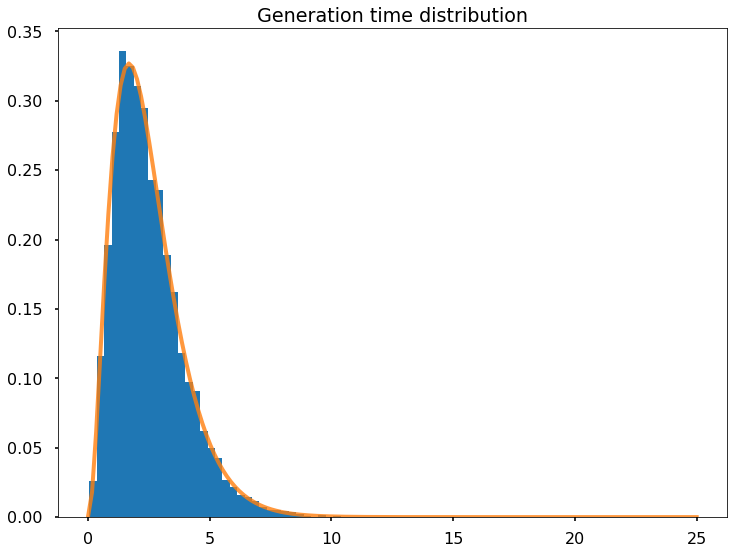

In [50]:
#Plot gamma pdf over samples from distribution
xrange = np.linspace(0,25,150)

fig,ax = plt.subplots(figsize=(12,9))
x = np.random.gamma(shape_gen, scale_gen, size = 10000)
print("Generation time: \nMean: %f.2" %np.mean(x))
print("Std: %f.2" %np.std(x))
w = ax.hist(x,bins=40, density=True)
ax.set_title("Generation time distribution")
ax.plot(xrange, gamma.pdf(xrange, a=shape_gen, scale=scale_gen), linewidth=4,alpha=0.8)

In [66]:
trunc_days = 21
shift=0
xmids = [x+shift for x in range(trunc_days+1)] #Find midpoints for discretisation
gamma_vals = gamma.pdf(xmids, a=shape_gen, scale=scale_gen)
disc_gamma = gamma_vals/sum(gamma_vals)

In [67]:
print("Sum of gamma values is " + str(sum(gamma_vals))+"; \n Sum of discretised gamma values is " + str(sum(disc_gamma)))

Sum of gamma values is 0.9936691617045523; 
 Sum of discretised gamma values is 1.0000000000000002


Text(0.5, 0, 'Days')

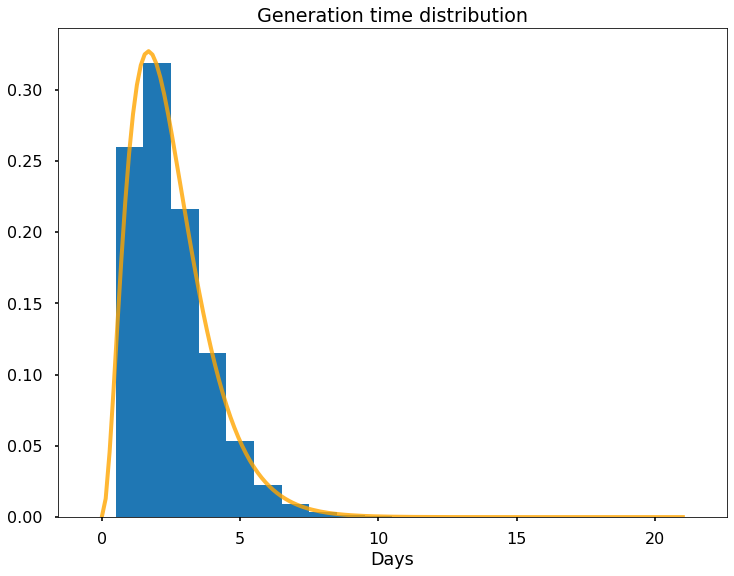

In [72]:
xrange = np.linspace(0,trunc_days,150)
fig,ax = plt.subplots(figsize=(12,9))
w = ax.bar(xmids,height=disc_gamma, width=1)
ax.set_title("Generation time distribution")
ax.plot(xrange, gamma.pdf(xrange, a=shape_gen, scale=scale_gen), linewidth=4,alpha=0.8, color="orange")
ax.set_xlabel('Days')

### Part 2b: Actually calculating $\Lambda$

In [85]:
# We use the total number of infected individuals, so use total I.
I_total = df_total.drop('local',1)


Timestamp('2020-07-25 00:00:00')

In [90]:
#Summing over s from 1 to t means that t is the maximum value of the generation interval. 
#21 here. So we should filter the data to 21 days before whenever 
I_total=I_total.reset_index()

In [91]:
#Test on one state before parallelising?
onestate='NSW'
input_state = I_total[I_total.STATE=='NSW']

In [102]:
tmax = input_state['infection_date'].max()

In [103]:
#input a vector of infection dates and total values.
tstart= tmax-np.timedelta64(trunc_days,'D')


In [145]:
relevant_dates = pd.date_range(tstart, tmax-np.timedelta64(1,'D'))
reldates = input_state['total'][input_state.infection_date.isin(relevant_dates)]
ws = [*reversed(disc_gamma[1:(trunc_days+1)])]
lambda_t=sum(reldates*ws)

In [146]:
lambda_t

7.002299299794061

Timestamp('2020-07-22 00:00:00')